In [ ]:
#pip install implicit==0.4.8 --no-use-pep517

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('C:/Users/я/Desktop/ml.bis/retail_train.csv')
data.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [5]:
items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.columns = ['item_id', 'sales_value_sum']
items_weights['item_weight'] = items_weights['sales_value_sum'] / items_weights['sales_value_sum'].sum()
items_weights = items_weights[['item_id','item_weight']]

In [6]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    
    recs = np.random.choice(items_weights['item_id'], n, p=items_weights['item_weight'],replace=False)

    return recs.tolist()

In [7]:
%%time
# your_code


result['weight_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

result.head(2)

CPU times: total: 5.19 s
Wall time: 5.21 s


,user_id,actual,weight_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[910032, 1116733, 825994, 1015548, 985105]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[7024990, 842470, 1070702, 940046, 1112038]"


In [8]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [9]:
items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

,user_id,actual,weight_recommendation,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[910032, 1116733, 825994, 1015548, 985105]","[6602435, 7447585, 1981189, 848194, 98696]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[7024990, 842470, 1070702, 940046, 1112038]","[12132552, 1537363, 914915, 9419952, 961846]"


In [10]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [11]:
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

,user_id,actual,weight_recommendation,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[910032, 1116733, 825994, 1015548, 985105]","[6602435, 7447585, 1981189, 848194, 98696]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[7024990, 842470, 1070702, 940046, 1112038]","[12132552, 1537363, 914915, 9419952, 961846]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [12]:
import os, sys
from metrics import precision_at_k, recall_at_k

In [13]:
result.apply(lambda row: precision_at_k(row['weight_recommendation'], row['actual']), axis=1).mean()

0.02252693437806077

In [14]:
# your_code
for name_col in result.columns[1:]:
    print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

1.0:actual
0.0225:weight_recommendation
0.0007:random_recommendation
0.1552:popular_recommendation


### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [15]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [16]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""

    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [17]:
result['random_recommendation_5k'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result.head(2)

,user_id,actual,weight_recommendation,random_recommendation,popular_recommendation,random_recommendation_5k
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[910032, 1116733, 825994, 1015548, 985105]","[6602435, 7447585, 1981189, 848194, 98696]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1037340, 952925, 1134810, 5570048, 1126899]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[7024990, 842470, 1070702, 940046, 1112038]","[12132552, 1537363, 914915, 9419952, 961846]","[6534178, 6533889, 1029743, 6534166, 1082185]","[9573206, 1097849, 6463742, 1009200, 849264]"


In [18]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 77777

In [19]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

In [20]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

C:\Users\я\Downloads\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Лучшее К = 1, Качество precision_at_k: 0.2199


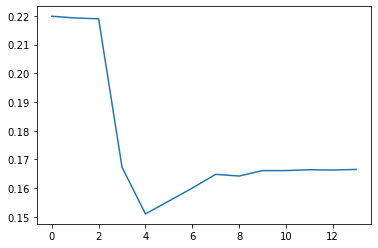

In [21]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
for i in range(1,15):
  model = ItemItemRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

  model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
            show_progress=False)
  result[f'K={i}'] = result['user_id'].\
      apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                      model.recommend(userid=userid_to_id[x], 
                                      user_items=sparse_user_item,   # на вход user-item matrix
                                      N=5, 
                                      filter_already_liked_items=False, 
                                      filter_items=[itemid_to_id[77777]], 
                                      recalculate_user=True)])

model_metrics = []
for name_col in result.columns[2:]:
    model_metrics.append(round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4))
plt.plot(model_metrics)
top_param_k = np.argmax(model_metrics) + 1
print(f'Лучшее К = {top_param_k}, Качество precision_at_k: {model_metrics[top_param_k - 1]}' )